In [37]:
import serial
import serial.tools.list_ports
import pyvisa
import matplotlib.pyplot as plt
import TeledyneLeCroyPy
import numpy as np
import pandas as pd
import scipy as sp
import time
from datetime import datetime
import matplotlib.colors as mcolors

rm = pyvisa.ResourceManager()
print(rm.list_resources())

serial.tools.list_ports.comports(include_links=True)

# to deal with already initialised oscilloscope
lecroy = None

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB0::9::INSTR', 'GPIB0::23::INSTR')


In [46]:
ps = rm.open_resource('GPIB0::23::INSTR')
print(ps.query('*IDN?'))

ps.write(':OUTP:LOW FLO')
ps.write(':OUTP:OFF:AUTO ON')
ps.write(':OUTP:PROT ON')
ps.write(':OUTP:RES:MODE FIX')
ps.write(':OUTP:RES:SHUN DEF')
ps.write(':SOUR:FUNC:MODE CURR')
ps.write(':SOUR:CURR:MODE FIX')
ps.write(':SOUR:CURR:LEV -1e-6')
ps.write(':DISP:ENAB OFF')
ps.write(':DISP:TEXT:DATA "pFREYA16"')
ps.write(':DISP:TEXT:STAT ON')
ps.write(':OUTP:STAT ON')

print(f'''
Low terminal: {ps.query(':OUTP:LOW?')[:-1]}
Auto output off: {ps.query(':OUTP:OFF:AUTO?')[:-1]}
Protection: {ps.query(':OUTP:PROT?')[:-1]}
Resistance mode: {ps.query(':OUTP:RES:MODE?')[:-1]}
Shunt resistance : {ps.query(':OUTP:RES:SHUN?')[:-1]}
Output current mode: {ps.query(':SOUR:CURR:MODE?')[:-1]}
Output current level: {ps.query(':SOUR:CURR:LEV?')[:-1]}
Output voltage range: {ps.query(':SOUR:VOLT:RANG?')[:-1]}
Output status: {ps.query(':OUTP:STAT?')[:-1]}
	''')

Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


Low terminal: FLO
Auto output off: 1
Protection: 1
Resistance mode: FIX
Shunt resistance : +2.00000000E+009
Output current mode: FIX
Output current level: -1.00000000E-006
Output voltage range: +2.00000000E+000
Output status: 1
	


In [39]:
pg = rm.open_resource('GPIB0::9::INSTR')
print(pg.query('*IDN?'))

csa_reset_n_pattern = ''.join([f'{i}' for i in [1]*20 + [0]*980])
csa_reset_n_length = str(len(csa_reset_n_pattern))
csa_reset_n_length_length = str(len(str(len(csa_reset_n_pattern))))

pg.write('*RST')
pg.write(f':TRIG:COUN {csa_reset_n_length}')
pg.write(f':TRIG:SOUR INT')
pg.write(f':PULS:PER 15NS')
pg.write(f':PULS:DCYC1 50PCT')
pg.write(f':PULS:DCYC2 50PCT')
pg.write(f':PULS:TRAN1 3NS')
pg.write(f':PULS:TRAN2 3NS')
pg.write(':DIG:STIM:PATTERN:STAT ON')
pg.write(f':DIG:STIM:PATTERN:DATA1 #{csa_reset_n_length_length}{csa_reset_n_length}{csa_reset_n_pattern}')
pg.write(f':DIG:STIM:PATTERN:PRES2 2,{csa_reset_n_length}')
pg.write(f':DIG:STIM:PATTERN:DATA3 #{csa_reset_n_length_length}{csa_reset_n_length}{csa_reset_n_pattern}')
pg.write(f':DIG:STIM:SIGN1:FORM NRZ')
pg.write(f':DIG:STIM:SIGN2:FORM NRZ')
pg.write(':OUTP1:IMP:INT 50OHM')
pg.write(':OUTP1:IMP:EXT 100OHM')
pg.write(':OUTP2:IMP:INT 50OHM')
pg.write(':OUTP2:IMP:EXT 100OHM')
pg.write(':VOLT1:LEV:HIGH 1.2V')
pg.write(':VOLT1:LEV:LOW 0V')
pg.write(':VOLT2:LEV:HIGH 1.2V')
pg.write(':VOLT2:LEV:LOW 0V')
pg.write(':OUTP1 ON')
pg.write(':OUTP2 ON')

print(f'''
Number of pattern positions: {pg.query(':TRIG:COUN?')[:-1]}
Source of the trigger: {pg.query(':TRIG:SOUR?')[:-1]}
Period of the pulse: {pg.query(':PULS:PER?')[:-1]}
Duty cycle of the pulse: {pg.query(':PULS:DCYC1?')[:-1]}
Rise time of the pulse: {pg.query(':PULS:TRAN1?')[:-1]}
Type of pulse: PATTERN
CH1 data: 20 1's, 980 0's
CH2 data: as the clock
STRB data: 20 1's, 980 0's
Type of the pulse: {pg.query(':DIG:STIM:SIGN1:FORM?')[:-1]}
Internal impedance (source): {pg.query(':OUTP1:IMP:INT?')[:-1]}
External impedance (termination): {pg.query(':OUTP1:IMP:EXT?')[:-1]}
High level: {pg.query(':VOLT1:LEV:HIGH?')[:-1]}
Low level: {pg.query(':VOLT1:LEV:LOW?')[:-1]}
Output 1 status: {pg.query(':OUTP1?')[:-1]}
Output 2 status: {pg.query(':OUTP2?')[:-1]}
	''')

HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


Number of pattern positions: +1000
Source of the trigger: IMM
Period of the pulse: +1.5000E-08
Duty cycle of the pulse: +5.0000E+01
Rise time of the pulse: +3.0000E-09
Type of pulse: PATTERN
CH1 data: 20 1's, 980 0's
CH2 data: as the clock
STRB data: 20 1's, 980 0's
Type of the pulse: NRZ
Internal impedance (source): +5.0000E+01
External impedance (termination): +1.0000E+02
High level: +1.2000E+00
Low level: +0.0000E+00
Output 1 status: 1
Output 2 status: 1
	


In [40]:
if lecroy is None:
	lecroy = TeledyneLeCroyPy.LeCroyWaveRunner('TCPIP0::169.254.1.214::inst0::INSTR')
print(lecroy.idn)

LECROY,WP804HD,LCRY4608N02718,10.0.0


In [55]:
# for each step set a current level, take some data
# next plot everything and calculate statistics

# The integral in the range is given by Iinj_int and should be converted to PH_EQ by means
#  of the following eq: PH_EQ = Iinj_int*2.28e16 keV/C / 9 keV = Iinj_int * 2.53e15

# The general integral for a trap(t-t_i,t_r,t_r,T), where t_i is the arrival time, t_r is the rise time and its the same as the fall time, T is the period
#  of pulse + rest (50% duty cycle) is equal to T/2-t_r
# Therefore Iinj_int = (T/2-t_r)*Iin = Qin

# With 0 A there is actually a negative injection (yay!)
# 	Evaluating the offset (@ 9keV, sim) at 0 is 6.16 eq ph or 2.43fA. With a current of 0.02 uA it goes away. In real life it goes with 0.06 uA.
# With max it is not perfect
# 	doing the same as above, one gets a correction factor of around 105.8fA/103.2fA
T = 30e-9 # s
t_r = 3e-9 # s
N_pulses = 10 # adimensional
conv_kev_c = 3.65/1000 * 1/1.602e-19 # Energy in silicon for e-/h * no of electrons per coulomb [keV/e-] * [e-/C]
config_bits = [1,1,0,1,0,1,1]
csa_bits = config_bits[0:2]
shap_bits = config_bits[3:5]
channel = 2 # 1 csa 2 shap
match csa_bits:
	case [0,1]:
		photon_energy = 9 # keV
		offset_charge = 8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 1.8e-6 # A
		corr_fact = 1 #105.8/103.2
	case [0,0]:
		photon_energy = 25 # keV
		offset_charge = 8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 4.3e-6 #3.5e-6 # A
		corr_fact = 1 #105.8/103.2
	case [1,0]:
		photon_energy = 18 # keV
		offset_charge = 8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 3.5e-6 # A
		corr_fact = 1 #105.8/103.2
	case [1,1]:
		photon_energy = 5 # keV
		offset_charge = 0 #8.5e-15 # C *tentative
		min_current = .07e-6 # A
		max_current = 1e-6 # A
		corr_fact = 1 #105.8/103.2
match shap_bits:
	case [1,0]: peaking_time = 432 # ns
	case [0,0]: peaking_time = 234 # ns
	case [0,1]: peaking_time = 332 # ns
	case [1,1]: peaking_time = 535 # ns

current_lev = -1 * np.linspace(min_current,max_current,20)
iinj_int = current_lev * (T/2-t_r) * N_pulses + offset_charge
eq_ph = -1 * iinj_int * corr_fact * conv_kev_c / photon_energy
config_bits_str = ''.join([str(x) for x in config_bits])
print(f'current range: {current_lev[0]}, {current_lev[-1]}')
print(f'Injection integral (min and max): {iinj_int[0]}, {iinj_int[-1]}')
print(f'photon energy @ {photon_energy} keV: {eq_ph[0]}, {eq_ph[-1]}')
print(f'Config bits: {config_bits_str}')

current range: -7e-08, -1e-06
Injection integral (min and max): -8.4e-15, -1.1999999999999997e-13
photon energy @ 5 keV: 38.27715355805243, 546.8164794007489
Config bits: 1101011


In [29]:
print(lecroy.query('C2:CRVA? HREL').split(',')[2])

-11E-3


In [56]:
channel_name = 'csa' if channel == 1 else 'shap'
gain = 5.6/2 if channel == 1 else 5.6/2
N_samples = 100

df = pd.DataFrame()
df['Current level step'] = np.arange(len(current_lev))
df['Current level (A)'] = current_lev
df['Equivalent photons'] = eq_ph
df['Voltage output average (V)'] = None
df['Voltage output std (V)'] = None
for i, cl in enumerate(current_lev):
	# set current level
	ps.write(f':SOUR:CURR:LEV {cl}')
	time.sleep(0.005)
	data = []
	# N sample to average and extract std from
	for _ in range(N_samples):
		data.append(float(lecroy.query(f'C{channel}:CRVA? HREL').split(',')[2]))
		time.sleep(0.03)
	
	df.loc[i,'Voltage output average (V)'] = np.average(data)/gain
	df.loc[i,'Voltage output std (V)'] = np.std(data)/gain

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
if channel == 1:
	df['Voltage output average (V)'] = -1*df['Voltage output average (V)']

df.to_csv(f'G:/My Drive/PHD/FALCON/measures/transcharacteristics/{channel_name}/{channel_name}_{config_bits_str}_nominal_{datetime_str}.tsv', '\t')

In [20]:
df = pd.read_csv('G:/My Drive/PHD/FALCON/measures/transcharacteristics/shap/shap_0101011_nominal_050424_190634.tsv',sep='\t')
datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
channel_name = 'shap'

LinregressResult(slope=0.002949518026546556, intercept=0.0008774479591837081, rvalue=0.997330724804272, pvalue=6.470077973737836e-22, stderr=5.0897596031154896e-05, intercept_stderr=0.0076210904074819775)


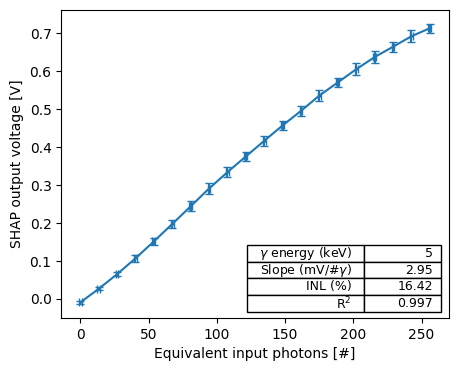

In [57]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
ax.errorbar(
	np.linspace(0,256,20),
	df['Voltage output average (V)'],
	xerr=np.tile(1, df.shape[0]),
	yerr=df['Voltage output std (V)'],
	fmt='s', markersize=1, capsize=3, linestyle='-')
ax.set_xlabel('Equivalent input photons [#]')
ax.set_ylabel(f'{channel_name.upper()} output voltage [V]')

from scipy import stats
eq_ph_s = 70
eq_ph_e = 200
ln = stats.linregress(
	#df[df['Equivalent photons'].between(eq_ph[0],eq_ph[-1])]['Equivalent photons'].astype(float),
	np.linspace(0,256,20),
	df[df['Equivalent photons'].between(eq_ph[0],eq_ph[-1])]['Voltage output average (V)'].astype(float))
linear_output = ln.intercept + ln.slope*eq_ph
max_diff = np.max(df['Voltage output average (V)'] - linear_output)
inl = 100 * np.abs(max_diff) / ln.slope / 256
print(ln)
ax.table([
	['$\\gamma$ energy (keV)',f'{photon_energy}'],
	['Slope (mV/#$\\gamma$)',f'{np.round(ln.slope*10**3,3)}'],
	['INL (%)',f'{np.round(inl,2)}'],
	['R$^2$',np.round(ln.rvalue,3)],
	], colWidths=[.3,.2], loc='lower right')
plt.savefig(f'G:/My Drive/PHD/FALCON/measures/transcharacteristics/{channel_name}/{channel_name}_{config_bits_str}_nominal_{datetime_str}.pdf',dpi=300)